In [1]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline

# 한글폰트
import os
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

import numpy as np

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
emd = geopandas.read_file('dataset\EMD_20220324\emd.shp', encoding = 'euc-kr')
emd = emd.to_crs(epsg=4326)
sig = geopandas.read_file('dataset\SIG_20220324\sig.shp', encoding = 'euc-kr')
sig = sig.to_crs(epsg=4326)

seoul_EMD = emd[emd['EMD_CD'].str.startswith('11')]
seoul_sig = sig[sig['SIG_CD'].str.startswith('11')]

display(seoul_EMD.head())
display(seoul_sig.head())

seoul_EMD["SIG_CD"] = seoul_EMD["EMD_CD"].str[:5]
seoul = pd.merge(seoul_sig, seoul_EMD, how='left', left_on='SIG_CD', right_on="SIG_CD")

seoul2 = seoul[["SIG_CD", 'SIG_KOR_NM', 'EMD_CD', 'EMD_KOR_NM', 'geometry_y']]
seoul2

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.97400 37.58654, 126.97401 37.586..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."


,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((127.00864 37.58047, 127.00871 37.580..."
1,11140,Jung-gu,중구,"POLYGON ((127.02314 37.57196, 127.02336 37.571..."
2,11170,Yongsan-gu,용산구,"POLYGON ((126.96918 37.55566, 126.96917 37.554..."
3,11200,Seongdong-gu,성동구,"POLYGON ((127.04341 37.57234, 127.04524 37.571..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((127.10166 37.57240, 127.10224 37.572..."


c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\geopandas\geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,SIG_CD,SIG_KOR_NM,EMD_CD,EMD_KOR_NM,geometry_y
0,11110,종로구,11110101,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110,종로구,11110102,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110,종로구,11110103,궁정동,"POLYGON ((126.97400 37.58654, 126.97401 37.586..."
3,11110,종로구,11110104,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110,종로구,11110105,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."
...,...,...,...,...,...
462,11740,강동구,11740106,둔촌동,"POLYGON ((127.15669 37.53756, 127.15654 37.537..."
463,11740,강동구,11740107,암사동,"POLYGON ((127.14353 37.55490, 127.14343 37.554..."
464,11740,강동구,11740108,성내동,"POLYGON ((127.13424 37.53556, 127.13423 37.535..."
465,11740,강동구,11740109,천호동,"POLYGON ((127.14153 37.55080, 127.14154 37.550..."


### B049 전처리

In [4]:
f = open("DataSet/심야약국_원본데이터반출/B049. 서울시 가족관계등록 신고현황 통계/2. 파일데이터/TN_PF_RRP_INCDNT_PROCESS_CURSTT.txt", 'r', encoding='utf-8')
text = f.read()
text = text.replace("`", "")
f.close()

temp = open("B049.txt", 'w')
print(text, file=temp)
temp.close()

In [5]:
data049 = pd.read_csv("B049.txt", sep="|", encoding="cp949")
data049

,ctprvn_nm,signgu_nm,emd_nm,regist_se,inqire_ym,managt_cnt,ldadng_dt
0,서울특별시,서울특별시 강남구,서울특별시 강남구청,개명,201501,187,2017-11-21 16:58:47
1,서울특별시,서울특별시 강남구,서울특별시 강남구청,사망,201501,183,2017-11-21 16:58:47
2,서울특별시,서울특별시 강남구,서울특별시 강남구청,이혼,201501,61,2017-11-21 16:58:47
3,서울특별시,서울특별시 강남구,서울특별시 강남구청,출생,201501,418,2017-11-21 16:58:47
4,서울특별시,서울특별시 강남구,서울특별시 강남구청,혼인,201501,522,2017-11-21 16:58:47
...,...,...,...,...,...,...,...
11402,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,개명,202204,2,2022-05-25 15:08:21
11403,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,사망,202204,297,2022-05-25 15:08:21
11404,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,이혼,202204,97,2022-05-25 15:08:21
11405,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,출생,202204,1320,2022-05-25 15:08:21


In [6]:
data049["signgu_nm"].unique()

array(['서울특별시 강남구', '서울특별시 강동구', '서울특별시 강북구', '서울특별시 강서구', '서울특별시 관악구',
       '서울특별시 광진구', '서울특별시 구로구', '서울특별시 금천구', '서울특별시 노원구', '서울특별시 도봉구',
       '서울특별시 동대문구', '서울특별시 동작구', '서울특별시 마포구', '서울특별시 서대문구', '서울특별시 서초구',
       '서울특별시 성동구', '서울특별시 성북구', '서울특별시 송파구', '서울특별시 양천구', '서울특별시 영등포구',
       '서울특별시 용산구', '서울특별시 은평구', '서울특별시 종로구', '서울특별시 중구', '서울특별시 중랑구',
       '재외국민 가족관계등록사무소'], dtype=object)

In [7]:
data049["emd_nm"].unique()

array(['서울특별시 강남구청', '서울특별시 강동구청', '서울특별시 강북구청', '서울특별시 강서구청',
       '서울특별시 관악구청', '서울특별시 광진구청', '서울특별시 구로구청', '서울특별시 금천구청',
       '서울특별시 노원구청', '서울특별시 도봉구청', '서울특별시 동대문구청', '서울특별시 동작구청',
       '서울특별시 마포구청', '서울특별시 서대문구청', '서울특별시 서초구청', '서울특별시 성동구청',
       '서울특별시 성북구청', '서울특별시 송파구청', '서울특별시 양천구청', '서울특별시 영등포구청',
       '서울특별시 용산구청', '서울특별시 은평구청', '서울특별시 종로구청', '서울특별시 중구청',
       '서울특별시 중랑구청', '재외국민 가족관계등록사무소'], dtype=object)

### B055 데이터 전처리

In [8]:
f = open("DataSet/심야약국_원본데이터반출/B055. 서울시 장애인 등급별 자치구 거주통계/2. 파일데이터/TN_PF_PPS_DSPSN_ATDRC_TY.txt", 'r', encoding='utf-8')
text = f.read()
text = text.replace("`", "")
f.close()

temp = open("B055.txt", 'w')
print(text, file=temp)
temp.close()

In [9]:
data049 = pd.read_csv("B055.txt", sep="|", encoding="cp949")
data049.head()

,stdr_ym,atdrc_nm,physicl_dspsn_co,visual_dspsn_co,arss_dspsn_co,lang_dspsn_co,intel_dspsn_co,brain_dspsn_co,autism_dspsn_co,mental_dspsn_co,kidney_dspsn_co,heart_dspsn_co,rsporg_dspsn_co,liver_dspsn_co,face_dspsn_co,ostm_urstm_dspsn_co,eplpsy_dspsn_co,ldadng_dt
0,2015,강남구,7251,1685,1474,125,996,1809,498,808,754,72,109,135,19,91,52,2018-08-09 11:24:54
1,2015,강동구,8781,1828,1577,165,1246,2029,336,574,712,67,85,115,16,109,62,2018-08-09 11:24:54
2,2015,강북구,8515,2009,1835,129,1073,1840,115,690,629,33,99,74,13,131,58,2018-08-09 11:24:54
3,2015,강서구,13463,2797,3033,203,1835,2980,267,1572,1119,96,184,124,39,155,129,2018-08-09 11:24:54
4,2015,관악구,10216,2368,1997,147,1208,2034,193,828,783,56,90,104,21,122,63,2018-08-09 11:24:54


In [10]:
new_col = [
"기준년월",
"자치구명",
"지체장애인수",
"시각장애인수",
"청각장애인수",
"언어장애인수",
"지적장애인수",
"뇌병변장애인수",
"자폐성장애인수",
"정신장애인수",
"신장장애인수",
"심장장애인수",
"호흡기장애인수",
"간장애인수",
"안면장애인수",
"장루요루장애인수",
"뇌전증장애인수",
"적재일시"
]

In [11]:
data049.columns = new_col

In [12]:
data049 = data049.drop(["적재일시"], axis=1)
data049

,기준년월,자치구명,지체장애인수,시각장애인수,청각장애인수,언어장애인수,지적장애인수,뇌병변장애인수,자폐성장애인수,정신장애인수,신장장애인수,심장장애인수,호흡기장애인수,간장애인수,안면장애인수,장루요루장애인수,뇌전증장애인수
0,2015,강남구,7251,1685,1474,125,996,1809,498,808,754,72,109,135,19,91,52
1,2015,강동구,8781,1828,1577,165,1246,2029,336,574,712,67,85,115,16,109,62
2,2015,강북구,8515,2009,1835,129,1073,1840,115,690,629,33,99,74,13,131,58
3,2015,강서구,13463,2797,3033,203,1835,2980,267,1572,1119,96,184,124,39,155,129
4,2015,관악구,10216,2368,1997,147,1208,2034,193,828,783,56,90,104,21,122,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2017,용산구,3806,987,950,69,506,860,90,297,320,19,47,63,8,74,20
71,2017,은평구,9488,2302,2620,178,1686,2296,276,1128,768,49,138,127,26,163,56
72,2017,종로구,2853,736,713,47,372,610,105,263,230,18,23,40,6,28,20
73,2017,중구,2732,734,644,32,322,583,51,234,218,14,25,31,6,43,25


In [13]:
new_col = new_col[:-1]

In [14]:
data049_1 = data049.groupby(["자치구명", "기준년월"]).sum()
data049_2 = data049.groupby("자치구명").sum()
data049_2 = data049_2.drop("기준년월", axis=1)
data049_2

,지체장애인수,시각장애인수,청각장애인수,언어장애인수,지적장애인수,뇌병변장애인수,자폐성장애인수,정신장애인수,신장장애인수,심장장애인수,호흡기장애인수,간장애인수,안면장애인수,장루요루장애인수,뇌전증장애인수
자치구명,,,,,,,,,,,,,,,
강남구,21051,4987,4633,372,3030,5384,1572,2524,2284,192,333,413,59,272,147
강동구,25452,5447,5069,485,3800,6011,1029,1703,2150,186,270,352,49,341,190
강북구,25165,6039,5863,408,3336,5485,375,2123,1956,110,301,229,37,376,155
강서구,39984,8470,9746,659,5685,9045,881,4806,3542,257,522,384,110,484,378
관악구,29831,6998,6308,466,3730,6122,612,2540,2497,154,297,303,60,377,180
광진구,18385,3987,3974,272,2324,3907,417,1550,1581,123,174,197,27,299,147
구로구,26141,5610,5588,422,3337,5123,691,1690,1850,212,314,262,72,354,142
금천구,16625,3532,3695,263,2049,3207,266,1209,1210,165,167,107,45,220,113
노원구,39002,8344,8655,663,6170,9079,924,4368,2993,344,479,288,104,540,335


In [15]:
data3 = data049_2.sum(axis=1).to_frame("장애인 통계")
data3

,장애인 통계
자치구명,
강남구,47253
강동구,52534
강북구,51958
강서구,84953
관악구,60475
광진구,37364
구로구,51808
금천구,32873
노원구,82288


In [16]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
fitted = scaler.fit(data3)
data3_scale = scaler.transform(data3)

In [17]:
data4_scale = pd.DataFrame(data3_scale, columns=["장애인가중치"], index=data3.index)
data4_scale = data4_scale.reset_index()
data4_scale

,자치구명,장애인가중치
0,강남구,0.000000
1,강동구,0.329548
2,강북구,0.293604
3,강서구,2.352574
4,관악구,0.825086
5,광진구,-0.617098
6,구로구,0.284243
7,금천구,-0.897348
8,노원구,2.186271
9,도봉구,-0.136287


In [32]:
import seaborn as sns
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['STIXSizeFiveSym',
 'STIXSizeFourSym',
 'STIXGeneral',
 'cmmi10',
 'DejaVu Serif Display',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'DejaVu Sans Mono',
 'STIXNonUnicode',
 'DejaVu Sans',
 'DejaVu Serif',
 'cmtt10',
 'STIXSizeOneSym',
 'cmss10',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXNonUnicode',
 'DejaVu Sans',
 'DejaVu Serif',
 'STIXSizeThreeSym',
 'STIXSizeThreeSym',
 'STIXSizeOneSym',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'cmex10',
 'STIXGeneral',
 'DejaVu Sans Display',
 'DejaVu Serif',
 'cmb10',
 'STIXSizeFourSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'cmr10',
 'cmsy10',
 'Trebuchet MS',
 'Microsoft Tai Le',
 'Segoe UI Emoji',
 'Eras Medium ITC',
 'Arial',
 'Bodoni MT',
 'Calisto MT',
 'Lucida Bright',
 'Cooper Black',
 'Felix Titling',
 'Lucida Bright',
 'Segoe UI',
 'NanumBarunpen',
 'Calibri',
 'High Tower Text',
 'Nanum Pen Script',
 'Garamond',
 'Copperplate Gothic Light',
 'Eras Bold ITC',
 'Rockwell'

<AxesSubplot:xlabel='자치구명', ylabel='장애인가중치'>

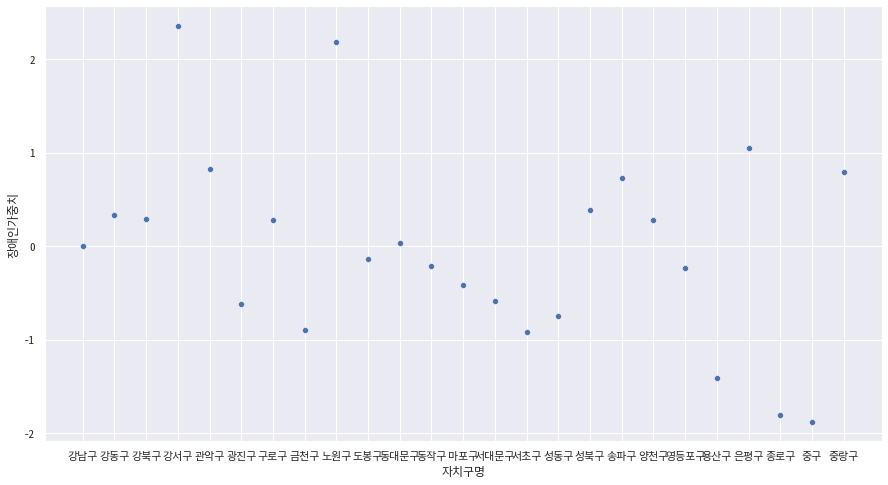

In [36]:
plt.rcParams['font.family'] = 'Noto Sans Mono CJK KR'
sns.set(rc = {'figure.figsize':(15,8)}, font="Noto Sans Mono CJK KR")
sns.scatterplot(x=data4_scale["자치구명"], y="장애인가중치", data=data4_scale)

<AxesSubplot:ylabel='장애인가중치'>

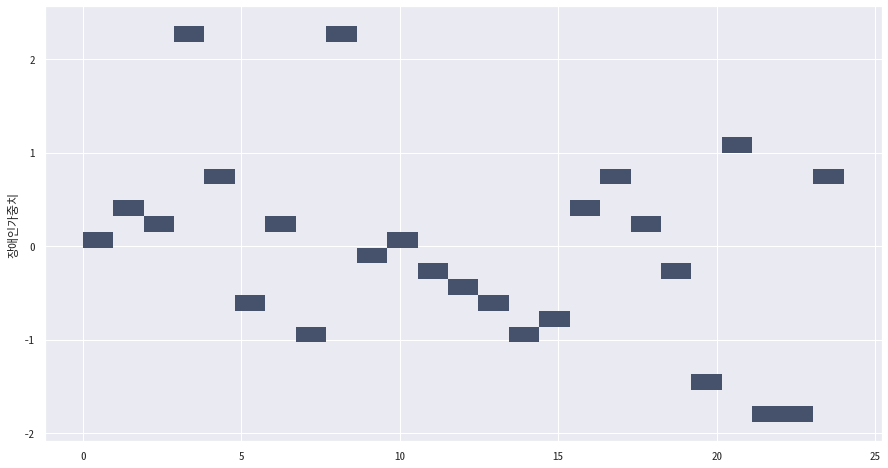

In [42]:
sns.histplot(x=data4_scale.index, y=data4_scale["장애인가중치"], bins=25, data=data4_scale)

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


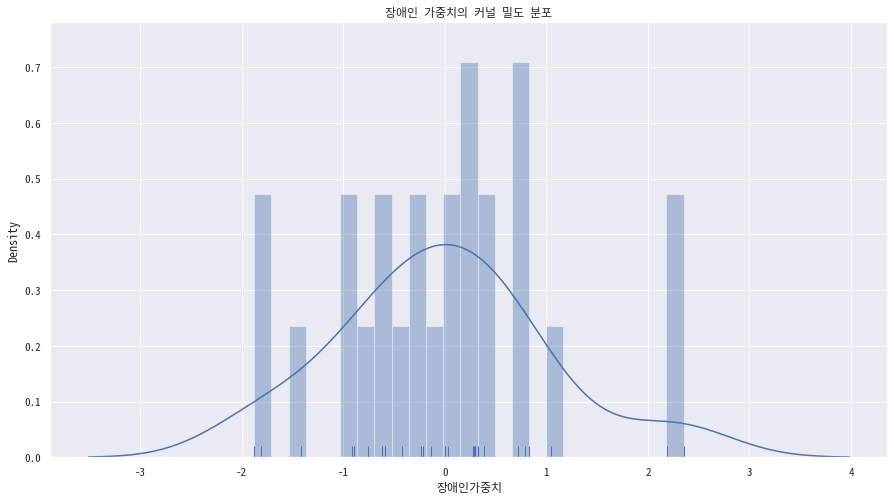

In [55]:
sns.distplot(data4_scale["장애인가중치"], bins=25, kde=True, rug=True)
plt.title("장애인 가중치의 커널 밀도 분포")
plt.show()

In [53]:
seoul3 = pd.merge(seoul2, data4_scale, how='left', left_on='SIG_KOR_NM', right_on="자치구명")
seoul3

,SIG_CD,SIG_KOR_NM,EMD_CD,EMD_KOR_NM,geometry_y,자치구명,장애인가중치
0,11110,종로구,11110101,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589...",종로구,-1.805367
1,11110,종로구,11110102,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584...",종로구,-1.805367
2,11110,종로구,11110103,궁정동,"POLYGON ((126.97400 37.58654, 126.97401 37.586...",종로구,-1.805367
3,11110,종로구,11110104,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582...",종로구,-1.805367
4,11110,종로구,11110105,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581...",종로구,-1.805367
...,...,...,...,...,...,...,...
462,11740,강동구,11740106,둔촌동,"POLYGON ((127.15669 37.53756, 127.15654 37.537...",강동구,0.329548
463,11740,강동구,11740107,암사동,"POLYGON ((127.14353 37.55490, 127.14343 37.554...",강동구,0.329548
464,11740,강동구,11740108,성내동,"POLYGON ((127.13424 37.53556, 127.13423 37.535...",강동구,0.329548
465,11740,강동구,11740109,천호동,"POLYGON ((127.14153 37.55080, 127.14154 37.550...",강동구,0.329548
